In [43]:
import os
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

path='images/images/'

# 
# read all files in train
train_files = os.listdir(path)
train_files = [f for f in train_files if f.endswith('.jpg')]

labels=[]

for f in train_files:
    label_splitted = f.split('_')
    if len(label_splitted) ==2:
        label = label_splitted[0]
    else:
        label = label_splitted[0] + '_' + label_splitted[1]
    labels.append(label)

In [44]:
import neptune

run = neptune.init_run(
    project="bernd.heidemann/fa22boxfordpets",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIzNjBlYzVkNi0zZTUwLTQ1ODYtODhlNC02NDUxNDg0MDdjNzUifQ==",
)  # your credentials

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/bernd.heidemann/fa22boxfordpets/e/FAB-64


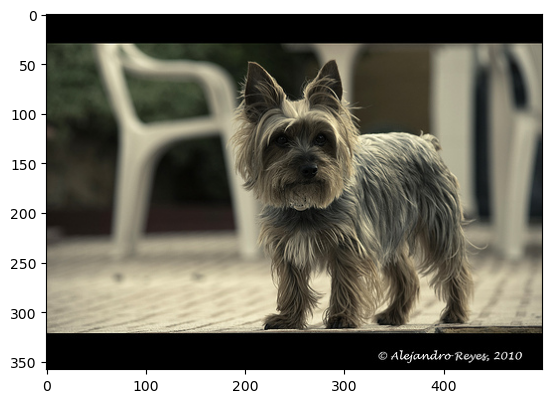

yorkshire_terrier


In [45]:


image= Image.open(path+train_files[-1])

plt.imshow(image)
plt.show()

print(labels[-1])

In [46]:
class_to_idx = {c:i for i,c in enumerate(np.unique(labels))}
idx_to_class = {i:c for c,i in class_to_idx.items()}

num_classes= len(class_to_idx)

In [47]:
class_to_idx

{'Abyssinian': 0,
 'Bengal': 1,
 'Birman': 2,
 'Bombay': 3,
 'British_Shorthair': 4,
 'Egyptian_Mau': 5,
 'Maine_Coon': 6,
 'Persian': 7,
 'Ragdoll': 8,
 'Russian_Blue': 9,
 'Siamese': 10,
 'Sphynx': 11,
 'american_bulldog': 12,
 'american_pit': 13,
 'basset_hound': 14,
 'beagle': 15,
 'boxer': 16,
 'chihuahua': 17,
 'english_cocker': 18,
 'english_setter': 19,
 'german_shorthaired': 20,
 'great_pyrenees': 21,
 'havanese': 22,
 'japanese_chin': 23,
 'keeshond': 24,
 'leonberger': 25,
 'miniature_pinscher': 26,
 'newfoundland': 27,
 'pomeranian': 28,
 'pug': 29,
 'saint_bernard': 30,
 'samoyed': 31,
 'scottish_terrier': 32,
 'shiba_inu': 33,
 'staffordshire_bull': 34,
 'wheaten_terrier': 35,
 'yorkshire_terrier': 36}

In [48]:
from joblib import Parallel, delayed
def load_image(file):
    image = Image.open(path + file)
    #reszie image to 224x224

    # convert to rgb
    if image.mode != 'RGB':
        image = image.convert('RGB')

    image = image.resize((224,224))
    
    label_splitted = file.split('_')
    if len(label_splitted) ==2:
        y = label_splitted[0]
    else:
        y = label_splitted[0] + '_' + label_splitted[1]
    y=class_to_idx[y]
    y=torch.tensor(int(y), dtype=torch.long)
    return (image,y)

all_images= Parallel(n_jobs=16)(delayed(load_image)(f) for f in tqdm(train_files))

  0%|          | 0/7390 [00:00<?, ?it/s]

In [49]:
import torchvision.transforms as transforms

good_transforms= transforms.Compose([
    # horizontal flip
    transforms.RandomHorizontalFlip(),
    # random rotation
    transforms.RandomRotation(30),
    # change brightness, saturation, hue
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05),
    # random perspective
    transforms.Resize((350, 350)),
    transforms.RandomCrop(224),
    transforms.ToTensor()
])


minimal_transforms= transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

current_transforms = good_transforms

In [50]:

class Dataset:
    def __init__(self, images_and_labels, transforms=None):
        self.images_and_labels = images_and_labels
        self.size = len(images_and_labels)
        self.transforms = transforms
        
    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):
        try:
            x,y=self.images_and_labels[idx]
            x = self.transforms(x)
        except Exception as e:
            print(f'Error at index {idx}, len of dataset is {self.size}') 
            print(e)
            raise
        return x, y

train_dataset = Dataset(all_images, current_transforms)
x, y = train_dataset[6000]
print(x)

tensor([[[0.3843, 0.3804, 0.3765,  ..., 0.5725, 0.5804, 0.5804],
         [0.3882, 0.3843, 0.3843,  ..., 0.6078, 0.6039, 0.5922],
         [0.4039, 0.4118, 0.4235,  ..., 0.6196, 0.6118, 0.5843],
         ...,
         [0.2471, 0.2471, 0.2510,  ..., 0.4196, 0.4549, 0.4549],
         [0.2588, 0.2706, 0.2784,  ..., 0.4157, 0.4235, 0.4392],
         [0.2706, 0.2824, 0.2902,  ..., 0.4157, 0.4000, 0.4275]],

        [[0.4078, 0.4039, 0.3961,  ..., 0.5725, 0.5804, 0.5804],
         [0.4157, 0.4078, 0.4078,  ..., 0.6078, 0.6039, 0.6000],
         [0.4314, 0.4314, 0.4392,  ..., 0.6235, 0.6196, 0.5922],
         ...,
         [0.3569, 0.3569, 0.3608,  ..., 0.4627, 0.4902, 0.4980],
         [0.3608, 0.3765, 0.3922,  ..., 0.4627, 0.4667, 0.4863],
         [0.3725, 0.3882, 0.4039,  ..., 0.4667, 0.4510, 0.4824]],

        [[0.2588, 0.2510, 0.2431,  ..., 0.5451, 0.5529, 0.5490],
         [0.2667, 0.2627, 0.2627,  ..., 0.5961, 0.5922, 0.5686],
         [0.2941, 0.2902, 0.3059,  ..., 0.6118, 0.6118, 0.

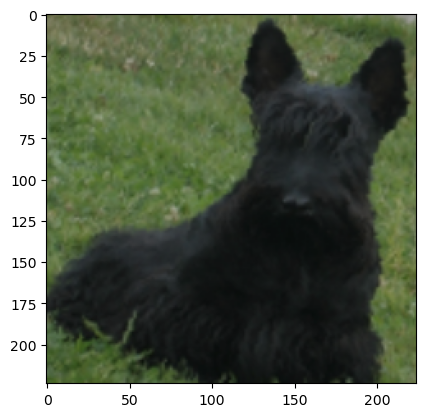

scottish_terrier


In [51]:
sample=x.permute(1,2,0).numpy()
plt.imshow(sample)
plt.show()
print(idx_to_class[y.item()])

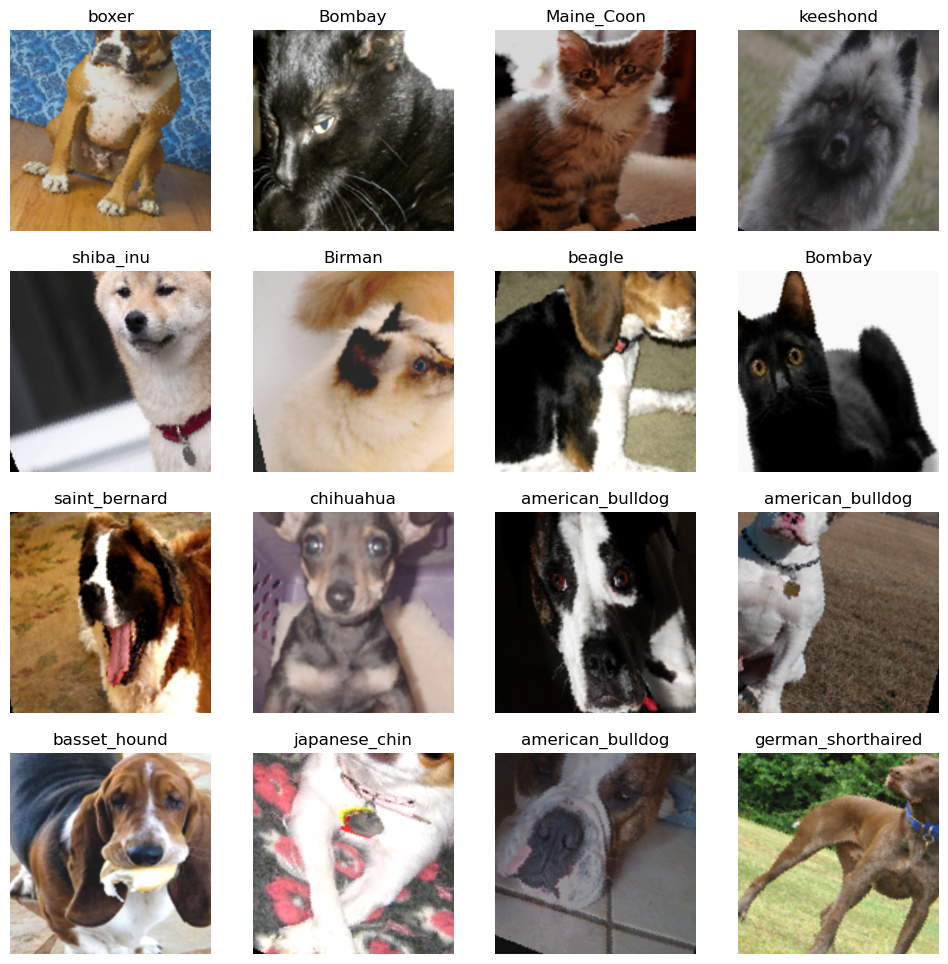

In [52]:
sample_loader= torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)

fig, ax= plt.subplots(4,4, figsize=(12,12))
for x,y in sample_loader:
    for i in range(16):
        xi= x[i].permute(1,2,0).numpy()
        ax[i//4, i%4].imshow(xi)
        ax[i//4, i%4].set_title(idx_to_class[y[i].item()])
        #remove axis
        ax[i//4, i%4].axis('off')
    break

In [53]:
class ConvBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1=torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.adjust_channels_conv_1=torch.nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.batch_norm_2d=torch.nn.BatchNorm2d(out_channels)
        self.relu=torch.nn.ReLU()
        
    def forward(self, input):
        x=input[0]
        identity=input[1]
        x=self.conv1(x)
        x=self.batch_norm_2d(x)
        x=self.relu(x)
        identity=self.adjust_channels_conv_1(identity)
        x=torch.add(x, identity)
        return x, identity
    
class ConvBlockMaxPool(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1=torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.adjust_channels_conv_1=torch.nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.batch_norm_2d=torch.nn.BatchNorm2d(out_channels)
        self.relu=torch.nn.ReLU()
        self.maxpool=torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
    def forward(self, input):
        x=input[0]
        identity=input[1]
        x=self.conv1(x)
        x=self.batch_norm_2d(x)
        x=self.relu(x)
        identity=self.adjust_channels_conv_1(identity)
        x=torch.add(x, identity)
        x=self.maxpool(x)
        identity=self.maxpool(identity)
        return x, identity
    
class DebugLayer(torch.nn.Module):
    def __init__(self, text):
        super().__init__()
        self.text=text
        
    def forward(self, input):
        x=input[0]
        identity=input[1]
        print(self.text, "x.shape:", x.shape)
        return x, identity


class CatsAndDogsModel(torch.nn.Module):
    def __init__(self, hidden_size=None, dropout=0.4):
        super().__init__()
        self.conv_layer=torch.nn.Sequential(
            ConvBlockMaxPool(3, 64,),       
            ConvBlockMaxPool(64, 128),          
            ConvBlockMaxPool(128, 256),         
            ConvBlockMaxPool(256, 512),         
            ConvBlockMaxPool(512, 1024),
            ConvBlockMaxPool(1024, 2048),
            #DebugLayer("nach conv_layer")
        )
     
        self.conv_size=2048*3*3
        self.lin1=torch.nn.Linear(self.conv_size, hidden_size)
        self.batch_norm_lin1=torch.nn.BatchNorm1d(hidden_size)
        self.lin2=torch.nn.Linear(hidden_size, num_classes)
        self.relu=torch.nn.ReLU()                           
        self.softmax=torch.nn.Softmax(dim=1)                
        self.dropout=torch.nn.Dropout(p=dropout)   
 
    def forward(self, x):
        #x=x.view(-1, 3, 32, 32)
        #print("x.shape nach x.view:", x.shape)
        original_x=x.clone()
        x, identity=self.conv_layer((x, original_x))
        
        #print("x.shape nach conv:", x.shape)
        # flatten
        x=x.view(-1, self.conv_size)
        #print("x.shape nach x.view:", x.shape)
        x=self.lin1(x)
        x=self.batch_norm_lin1(x)
        x=self.relu(x)
        x=self.dropout(x)
        x=self.lin2(x)
        #print("x.shape nach lin1:", x.shape)
        return x
    
# wir bauen das Modell
model=CatsAndDogsModel(hidden_size=100)
# wir bauen das Dataset
dataset_sample=Dataset(all_images, current_transforms)
# wir bauen den DataLoader
loader=torch.utils.data.DataLoader(dataset_sample, batch_size=13, shuffle=True)
# ein einziges Batch-Beispiel wird aus dem Dataloader geladen
for xb, yb in loader:
    print(model(xb).shape)
    assert model(xb).shape==torch.Size([13, num_classes]), "Error: model(xb).shape!=torch.Size([13, 10])"
    break


torch.Size([13, 37])


In [54]:

# split data into train and validation, using 80% for training and 20% for validation
# shuffled
train_idxs=np.random.choice(range(len(all_images)), int(0.8*len(all_images)), replace=False)
train_images=[all_images[i] for i in train_idxs]
validation_images=[all_images[i] for i in range(len(all_images)) if i not in train_idxs]

train_dataset=Dataset(train_images, current_transforms)
valid_dataset=Dataset(validation_images, minimal_transforms)

In [55]:
print(len(train_dataset), len(valid_dataset))

5912 1478


In [56]:
def get_accuracy(model, dataset):
    loader=torch.utils.data.DataLoader(dataset, batch_size=100, shuffle=False)
    model.eval()
    correct=0
    total=0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)   
            y_pred=model(xb)
            y_pred=torch.argmax(y_pred, dim=1)
            correct+=(y_pred==yb).sum().item()
            total+=len(yb)
    return correct/total

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

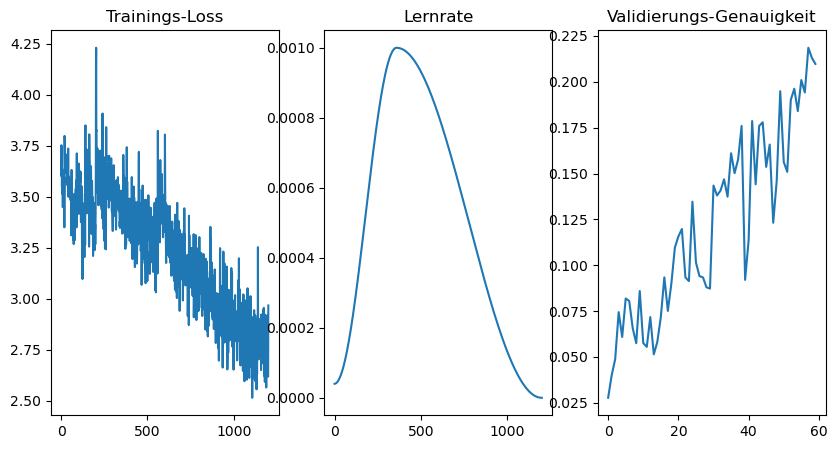

In [58]:
import neptune

#run = neptune.init_run(
#    project="bernd.heidemann/oxfordpets",
#    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIzNjBlYzVkNi0zZTUwLTQ1ODYtODhlNC02NDUxNDg0MDdjNzUifQ==",
#) 


lr=0.001
batch_size=100
epochs=20
hidden_size=1000
eval_steps=20

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

#device=torch.device('cpu')

train_loader=torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=16)
valid_loader=torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=16)

model=CatsAndDogsModel(hidden_size).to(device)
#weight_decay: Hohe Gewichte werden bestraft, um Overfitting zu vermeiden
optimizer=torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.001)
#RMSprop: Optimierungsalgorithmus
#optimizer=torch.optim.RMSprop(model.parameters(), lr=lr, weight_decay=0.0001)
# OneCycleLR: Lernrate wird während des Trainings erhöht und dann wieder verringert
scheduler=torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=len(train_loader), epochs=epochs)

# CrossEntropyLoss: Klassifikationsproblem mit mehreren Klassen
loss_func=torch.nn.CrossEntropyLoss()

losses=[]
valid_losses=[]
learning_rates=[]
accs=[]

best_acc=0
postfix={}
for i in range(epochs):
    model.train()
    bar= tqdm(train_loader, total=len(train_loader), leave=False)  
    bar.set_description(f"Epoch {i+1}/{epochs}")
    steps=0
    bar.set_postfix(postfix)
    for xb, yb in bar:
        steps+=1
        bar.update(1)
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()                   # Gradienten (Ableitungen) zurücksetzen
        pred=model(xb)                          # Forward-Propagation
        loss=loss_func(pred, yb)                # Loss berechnen
        loss.backward()                         # ableiten
        optimizer.step()                        # Gewichte aktualisieren
        losses.append(loss.item())              # Loss speichern
        run["train/loss"].log(loss.item())
        scheduler.step()                        # Lernrate aktualisieren
        learning_rates.append(scheduler.get_last_lr()[0])
        if steps%eval_steps==0:
            acc=get_accuracy(model, valid_dataset)
            accs.append(acc)
            if acc>best_acc:
                best_acc=acc
                torch.save(model.state_dict(), 'best_model.pth')
           
            postfix={
                    'loss': sum(losses[-eval_steps:])/eval_steps,
                    'lr': scheduler.get_last_lr()[0], 
                    'val_accuracy': acc
                 }
            bar.set_postfix(postfix)
            run["val/accuracy"].log(acc)
            run["train/lr"].log(scheduler.get_last_lr()[0])
            run["val/loss"].log(sum(losses[-eval_steps:])/eval_steps)
            
fig, ax=plt.subplots(1,3, figsize=(10,5))
ax[0].plot(losses)
ax[0].set_title('Trainings-Loss')
ax[1].plot(learning_rates)
ax[1].set_title('Lernrate')
ax[2].plot(accs)
ax[2].set_title('Validierungs-Genauigkeit')

plt.show()

In [ ]:
# save model

torch.save(model.state_dict(), 'model.pth')